In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
def nrcs_soil_api_pull(start_date, end_date):
    "API Reference: https://wcc.sc.egov.usda.gov/awdbRestApi/swagger-ui/index.html#/Data/getData"
    
    url = f'https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/data?stationTriplets=680%3ACO%3ASNTL%2C378%3ACO%3ASNTL%2C802%3ACO%3ASNTL%2C607%3ACO%3ASNTL%2C457%3ACO%3ASNTL%2C&elements=SMS%3A%2A&duration=DAILY&beginDate={start_date}&endDate={end_date}&periodRef=END&centralTendencyType=ALL&returnFlags=false&returnOriginalValues=false&returnSuspectData=false'
    
    response = requests.get(url)
    if response.status_code != 200:
        return response.status_code
    data = response.json()
    df = pd.DataFrame(data)

    expanded_values = []
    for _, row in df.iterrows():
        for data in row['data']:
            for value in data['values']:
                expanded_values.append({
                    'date': value.get('date'),
                    'elementCode': data.get('stationElement').get('elementCode'),
                    'station': row.get('stationTriplet'),
                    'value': value.get('value', 0),
                    'unit': data.get('stationElement').get('storedUnitCode'),
                    'height_depth': data.get('stationElement').get('heightDepth')
                })
    df = pd.DataFrame(expanded_values)
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'])
    df = df.convert_dtypes()
    return df

In [10]:
# df = nrcs_soil_api_pull('2000-01-01', '2024-12-31')
# df.to_parquet('data/nrcs_soil_moisture.parquet', index=False)
df = pd.read_parquet('data/nrcs_soil_moisture.parquet')
df = df.drop(columns=['unit', 'elementCode'])
display(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109747 entries, 0 to 109746
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          109747 non-null  datetime64[ns]
 1   station       109747 non-null  string        
 2   value         109747 non-null  Float64       
 3   height_depth  109747 non-null  Int64         
dtypes: Float64(1), Int64(1), datetime64[ns](1), string(1)
memory usage: 3.6 MB


None

,date,station,value,height_depth
0,2002-07-11,378:CO:SNTL,1.8,-2
1,2002-07-12,378:CO:SNTL,1.0,-2
2,2002-07-13,378:CO:SNTL,0.7,-2
3,2002-07-14,378:CO:SNTL,0.0,-2
4,2002-07-15,378:CO:SNTL,0.1,-2
...,...,...,...,...
109742,2024-08-27,802:CO:SNTL,0.4,-20
109743,2024-09-04,802:CO:SNTL,7.3,-20
109744,2024-09-05,802:CO:SNTL,2.1,-20
109745,2024-09-06,802:CO:SNTL,1.5,-20


In [5]:
display(df['station'].unique())
display(df['elementCode'].unique())

<StringArray>
['378:CO:SNTL', '457:CO:SNTL', '607:CO:SNTL', '680:CO:SNTL', '802:CO:SNTL']
Length: 5, dtype: string

<StringArray>
['SMS']
Length: 1, dtype: string

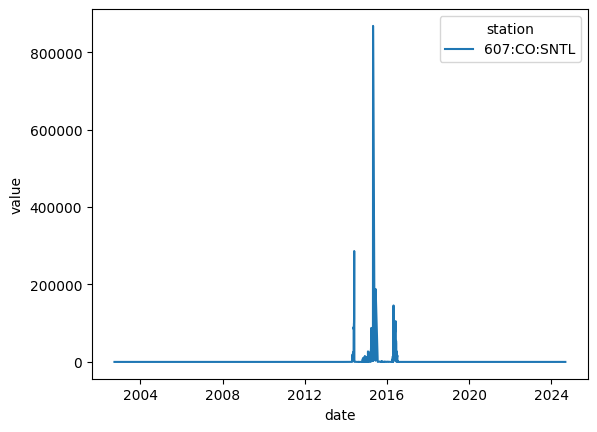

In [10]:
# Visualize
df_viz = df[(df['height_depth'] == -20) & (df['station'] == '607:CO:SNTL')]
sns.lineplot(data=df_viz, x='date', y='value', hue='station', legend=True)
plt.show()

noting some odd behavior in station 607 where soil moisture is apparently over 100%. Not sure if this is possible yet.

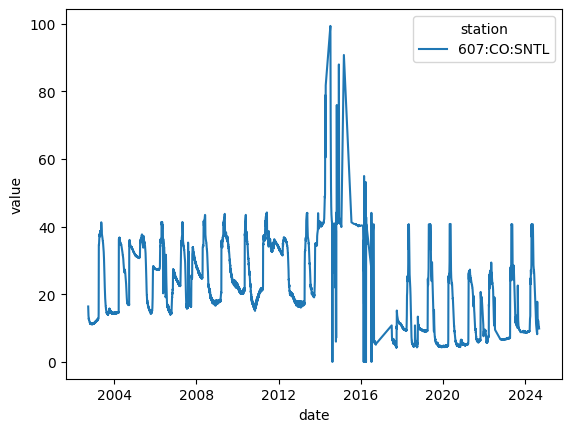

In [11]:
df_viz = df_viz[df_viz['value'] <= 100]
sns.lineplot(data=df_viz, x='date', y='value', hue='station', legend=True)
plt.show()

<Axes: xlabel='date', ylabel='value'>

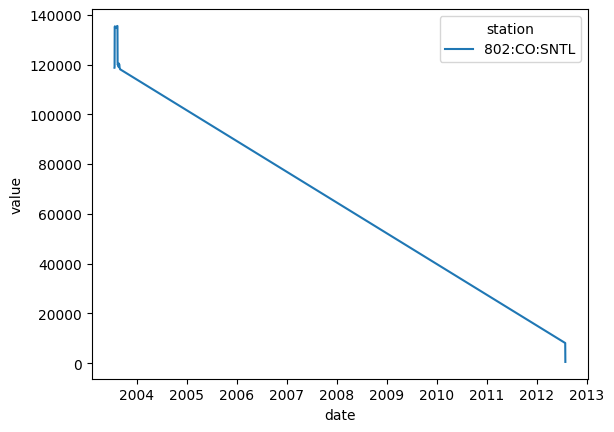

In [12]:
df_viz2 = df_viz = df[
    (df['height_depth'] == -20) & 
    (df['station'] == '802:CO:SNTL') & 
    (df['value'] >= 100)]

sns.lineplot(data=df_viz2, x='date', y='value', hue='station', legend=True)

It appears some stations may be unusable, or some smoothing/aggregating needs to be done prior to modeling.

<Axes: xlabel='date', ylabel='value'>

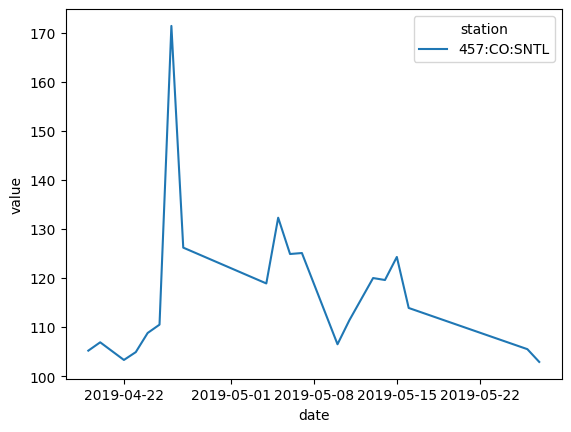

In [15]:
df_viz3 = df_viz = df[
    (df['height_depth'] == -20) & 
    (df['station'] == '457:CO:SNTL') & 
    (df['value'] >= 100)]

sns.lineplot(data=df_viz3, x='date', y='value', hue='station', legend=True)

In [24]:
# Pivot dataset to make each station/depth/val a feature
df['height_depth'] = df['height_depth'] * -1
df['station'] = df['station'].str.replace(':CO:SNTL', '')
pivot_df = df.pivot(index="date", columns=["station", "height_depth"])
pivot_df.columns = [f"soilmoisture_station{station}_{depth}ft" for _, station, depth in pivot_df.columns]
pivot_df = pivot_df.dropna()
display(pivot_df)

pivot_df.to_parquet('data/nrcs_soil_moisture_pivot.parquet', index=True)

,soilmoisture_station378_2ft,soilmoisture_station378_8ft,soilmoisture_station378_20ft,soilmoisture_station457_2ft,soilmoisture_station457_8ft,soilmoisture_station457_20ft,soilmoisture_station607_4ft,soilmoisture_station607_8ft,soilmoisture_station607_20ft,soilmoisture_station680_2ft,soilmoisture_station680_8ft,soilmoisture_station680_20ft,soilmoisture_station802_2ft,soilmoisture_station802_8ft,soilmoisture_station802_20ft
date,,,,,,,,,,,,,,,
2008-03-12,32.2,35.4,23.9,18.7,16.1,20.9,10.2,24.2,25.8,14.6,11.7,26.0,4.0,1.3,6.5
2008-03-13,32.1,35.5,24.2,18.5,16.4,20.9,10.5,24.4,25.3,14.5,12.0,26.2,3.8,1.3,6.5
2008-03-14,32.1,35.5,24.1,18.7,16.2,20.8,10.5,24.7,25.4,14.5,11.9,25.9,4.0,1.2,6.6
2008-03-15,32.1,35.6,24.1,18.7,16.3,20.9,10.3,24.4,25.4,14.7,11.7,26.2,4.0,1.4,6.9
2008-03-16,32.2,35.6,24.3,18.7,16.5,20.9,10.3,24.7,25.4,14.7,11.9,26.1,3.9,1.2,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-23,21.2,17.1,18.4,4.2,21.7,1.5,13.8,14.5,11.5,35.5,14.2,30.2,24.1,5.5,9.2
2021-07-24,19.6,17.0,18.4,3.8,21.6,1.6,13.4,14.1,11.3,33.7,13.9,30.2,24.0,5.3,8.7
2021-07-25,19.7,16.8,18.4,3.9,21.7,1.4,13.1,13.9,10.8,39.8,13.8,30.2,23.8,5.0,8.1
